## Time Series Forecasting

### Imports

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Classical time series
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# ARIMA hyperparameter selection
from pmdarima import auto_arima

# GARCH
from arch import arch_model

# ML
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

# XGBoost, LightGBM, CatBoost
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Deep Learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from scikeras.wrappers import KerasRegressor

# Keras Tuner for hyperparameter tuning
import keras_tuner as kt

# For warnings
import warnings
warnings.filterwarnings("ignore")


### Data Collection and Preprocessing:

[*********************100%%**********************]  1 of 1 completed

               Close
Date                
2010-01-04  7.643214
2010-01-05  7.656429
2010-01-06  7.534643
2010-01-07  7.520714
2010-01-08  7.570714


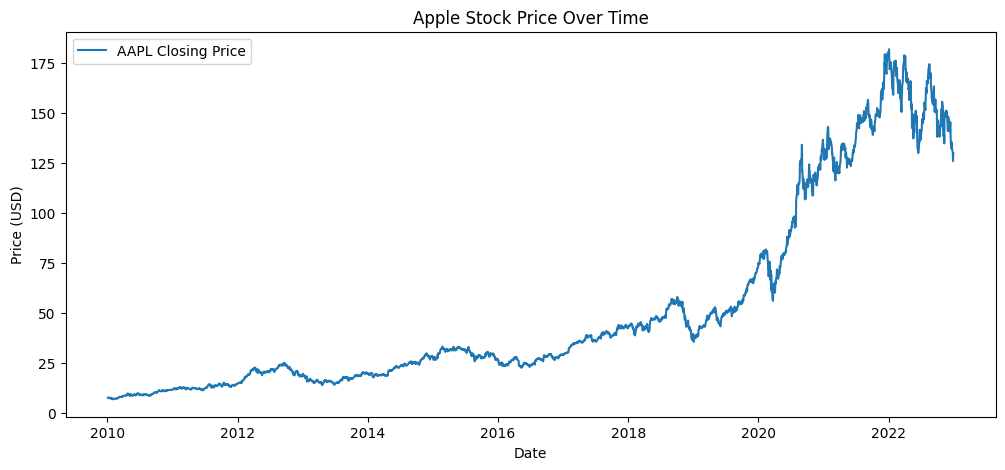

Statistical summary:
             Close
count  3272.000000
mean     51.321186
std      47.357062
min       6.858929
25%      18.967589
50%      29.815000
75%      56.777499
max     182.009995
ADF Statistic: -0.2877611181661428
p-value: 0.9272199267187228


In [35]:
# Getting data from YFinance
ticker = "AAPL"
df = yf.download(ticker, start="2010-01-01", end="2023-01-01")

# Focusing on the Close price
df = df[['Close']]
df.dropna(inplace=True)
print(df.head())

plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='AAPL Closing Price')
plt.title('Apple Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

print("Statistical summary:")
print(df.describe())

# ADF Test (Stationarity)
adf_result = adfuller(df['Close'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])


In [36]:
df['Returns'] = df['Close'].pct_change()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['Volatility'] = df['Returns'].rolling(window=20).std()

df.dropna(inplace=True)
print(df.head())


               Close   Returns     MA_20     MA_50  Volatility
Date                                                          
2010-03-16  8.016071  0.002725  7.564411  7.391336    0.012642
2010-03-17  8.004286 -0.001470  7.602929  7.398557    0.012552
2010-03-18  8.023214  0.002365  7.641714  7.405893    0.012546
2010-03-19  7.937500 -0.010683  7.678464  7.413950    0.012797
2010-03-22  8.026786  0.011249  7.721911  7.424071    0.012590


### Model Selection: Auto ARIMA for Optimal Parameters

In [37]:
stepwise_fit = auto_arima(
    df['Close'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(stepwise_fit.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11385.506, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11395.280, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11387.581, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11386.978, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11395.576, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11387.244, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11387.281, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11386.224, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11386.866, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11383.180, Time=1.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11384.923, Time=0.93 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11379.135, Time=0.92 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11387.815, Time=0.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11378.368, Time=1.80 sec
 ARIMA(4,1,3)(0,0,0

### ARIMA Model Training and Forecasting

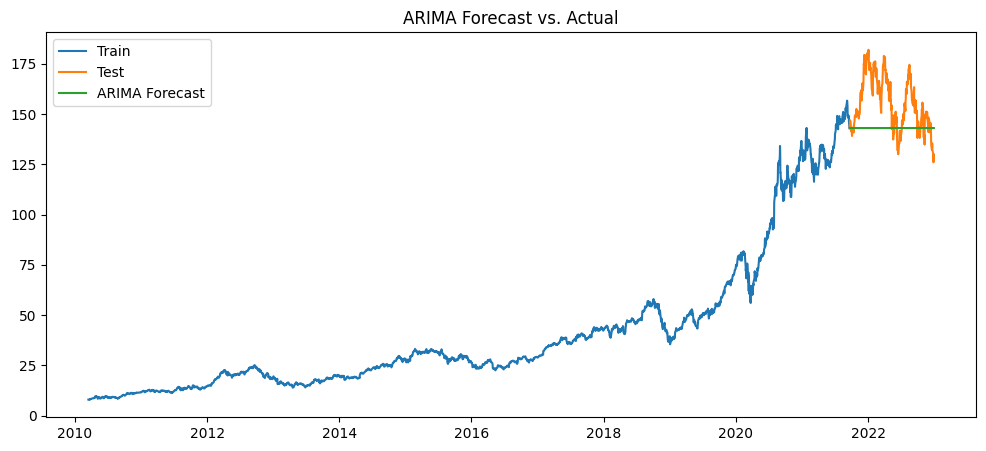

ARIMA RMSE: 17.765802587148247
ARIMA MAE: 14.08779063014772


In [38]:
train_size = int(len(df)*0.9)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Suppose auto_arima suggests (p,d,q) = (1,1,1)
model_arima = SARIMAX(
    train_data['Close'],
    order=(1,1,1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
arima_result = model_arima.fit(disp=False)

# Forecasting
arima_forecast = arima_result.forecast(steps=len(test_data))
arima_forecast.index = test_data.index

plt.figure(figsize=(12,5))
plt.plot(train_data['Close'], label='Train')
plt.plot(test_data['Close'], label='Test')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast vs. Actual')
plt.show()

arima_rmse = np.sqrt(mean_squared_error(test_data['Close'], arima_forecast))
arima_mae = mean_absolute_error(test_data['Close'], arima_forecast)
print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAE:", arima_mae)


### GARCH Model: Volatility Modeling and Forecasting

In [39]:
train_returns = train_data['Returns'] * 100  
test_returns = test_data['Returns'] * 100

garch_model = arch_model(train_returns.dropna(), vol='GARCH', p=1, q=1, dist='normal')
garch_result = garch_model.fit(update_freq=5, disp='off')
print(garch_result.summary())

# Forecasting volatility for the test period
garch_forecast = garch_result.forecast(horizon=len(test_returns), reindex=True)
variance_forecast = garch_forecast.variance.iloc[-1]
vol_forecast = np.sqrt(variance_forecast)
print("GARCH Volatility Forecast (last period):")
print(vol_forecast)


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5535.47
Distribution:                  Normal   AIC:                           11078.9
Method:            Maximum Likelihood   BIC:                           11102.8
                                        No. Observations:                 2900
Date:                Wed, Dec 25 2024   Df Residuals:                     2899
Time:                        20:52:17   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1829  3.062e-02      5.973  2.328e-09 [  0.123,  0.24

### Feature Lagging and Data Splitting

In [40]:
df_ml = df.copy()
df_ml['Close_shift_1'] = df_ml['Close'].shift(1)
df_ml['MA_20_shift_1'] = df_ml['MA_20'].shift(1)
df_ml['MA_50_shift_1'] = df_ml['MA_50'].shift(1)
df_ml['Vol_shift_1'] = df_ml['Volatility'].shift(1)
df_ml['Ret_shift_1'] = df_ml['Returns'].shift(1)
df_ml.dropna(inplace=True)

features = ['Close_shift_1','MA_20_shift_1','MA_50_shift_1','Vol_shift_1','Ret_shift_1']
X = df_ml[features]
y = df_ml['Close']

split_idx = int(len(X)*0.9)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


### XGBoost Tuning and Prediction

In [41]:
xgb_reg = xgb.XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
# TimeSeriesSplit for time series
tscv = TimeSeriesSplit(n_splits=3)

grid_search_xgb = GridSearchCV(
    xgb_reg,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1
)
grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_
threshold_up = 0.01
threshold_down = -0.01
strategy_df['Signal'] = np.where(
    strategy_df['Predicted_Close'] > strategy_df['Today_Close'] * (1 + threshold_up), 1,
    np.where(strategy_df['Predicted_Close'] < strategy_df['Today_Close'] * (1 + threshold_down), -1, 0)
)

print("Best XGBoost Params:", grid_search_xgb.best_params_)

xgb_pred = best_xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
print(f"XGBoost RMSE: {xgb_rmse:.4f}, MAE: {xgb_mae:.4f}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
XGBoost RMSE: 13.2950, MAE: 9.7694


### LightGBM Tuning and Evaluation

In [42]:
lgb_reg = LGBMRegressor(
    random_state=42,
    verbosity=-1  
)

param_grid_lgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
grid_search_lgb = GridSearchCV(
    lgb_reg,
    param_grid_lgb,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=0
)
grid_search_lgb.fit(X_train, y_train)
best_lgb = grid_search_lgb.best_estimator_

lgb_pred = best_lgb.predict(X_test)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_mae = mean_absolute_error(y_test, lgb_pred)
print(f"LightGBM RMSE: {lgb_rmse:.4f}, MAE: {lgb_mae:.4f}")


LightGBM RMSE: 13.6243, MAE: 10.0302


### CatBoost Tuning and Evaluation

In [43]:
cat_reg = CatBoostRegressor(verbose=False, random_state=42)

param_grid_cat = {
    'iterations': [50, 100],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 5]
}
grid_search_cat = GridSearchCV(
    cat_reg,
    param_grid_cat,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1
)
grid_search_cat.fit(X_train, y_train)
best_cat = grid_search_cat.best_estimator_

cat_pred = best_cat.predict(X_test)
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_pred))
cat_mae = mean_absolute_error(y_test, cat_pred)
print(f"CatBoost RMSE: {cat_rmse:.4f}, MAE: {cat_mae:.4f}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
CatBoost RMSE: 14.5543, MAE: 10.9176


### Data Scaling and Sequence Creation

In [44]:
df_dl = df[['Close']].copy()
dl_data = df_dl.values

scaler = MinMaxScaler()
dl_data_scaled = scaler.fit_transform(dl_data)

train_size_dl = int(len(dl_data_scaled)*0.9)
train_dl_scaled = dl_data_scaled[:train_size_dl]
test_dl_scaled = dl_data_scaled[train_size_dl:]

def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train_dl, y_train_dl = create_sequences(train_dl_scaled, seq_length)
X_test_dl, y_test_dl = create_sequences(test_dl_scaled, seq_length)

# Reshape
X_train_dl = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], 1))
X_test_dl = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], 1))


### LSTM Training and Evaluation

In [45]:
def build_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Basic training
lstm_model = build_lstm_model()
lstm_model.fit(
    X_train_dl, y_train_dl,
    epochs=5,  # short for demonstration
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

lstm_pred_scaled = lstm_model.predict(X_test_dl)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
actual_test = scaler.inverse_transform(y_test_dl.reshape(-1,1))

lstm_rmse = np.sqrt(mean_squared_error(actual_test, lstm_pred))
lstm_mae = mean_absolute_error(actual_test, lstm_pred)
print(f"LSTM RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")


Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.2915e-04 - val_loss: 9.8815e-04
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.7184e-04 - val_loss: 9.2143e-04
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3638e-04 - val_loss: 0.0010
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2700e-04 - val_loss: 8.7103e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM RMSE: 7.6666, MAE: 6.4575


###  Tuning for LSTM with Keras Tuner

In [46]:
def lstm_builder(hp):
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    lstm_builder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='lstm_tuner_dir',
    project_name='lstm_opt'
)
tuner.search(X_train_dl, y_train_dl, epochs=3, validation_split=0.1)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Units:", best_hps.get('units'), "Best Dropout:", best_hps.get('dropout_rate'))


Reloading Tuner from lstm_tuner_dir/lstm_opt/tuner0.json
Best Units: 96 Best Dropout: 0.1


### GRU Training and Evaluation

In [47]:
def build_gru_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(units, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

gru_model = build_gru_model()
gru_model.fit(
    X_train_dl, y_train_dl,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

gru_pred_scaled = gru_model.predict(X_test_dl)
gru_pred = scaler.inverse_transform(gru_pred_scaled)

gru_rmse = np.sqrt(mean_squared_error(actual_test, gru_pred))
gru_mae = mean_absolute_error(actual_test, gru_pred)
print(f"GRU RMSE: {gru_rmse:.4f}, MAE: {gru_mae:.4f}")


Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0039 - val_loss: 4.8205e-04
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.8296e-04 - val_loss: 4.3481e-04
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.0935e-04 - val_loss: 4.8196e-04
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.8290e-04 - val_loss: 5.2004e-04
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.9989e-04 - val_loss: 4.3589e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
GRU RMSE: 4.7684, MAE: 3.9532


### Hypothetical Trading Strategy and Risk Metrics

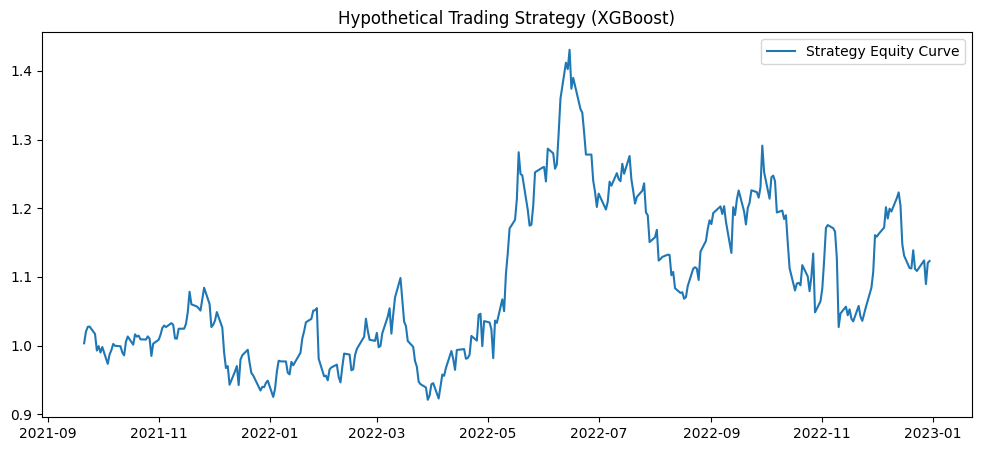

Sharpe Ratio: 0.4385931384165268
Sortino Ratio: 0.6338948561318736


In [48]:
# Already have best_xgb and X_test, y_test
pred_series = pd.Series(best_xgb.predict(X_test), index=X_test.index, name='Predicted_Close')
actual_series = y_test.copy()  # actual next-day close

strategy_df = pd.DataFrame({
    'Actual_Close': actual_series,
    'Predicted_Close': pred_series
})

# 'Today_Close' for a day-lag comparison
strategy_df['Today_Close'] = df_ml.loc[strategy_df.index, 'Close_shift_1']  # close of previous day

# Signal: +1 if predicted > today's close, -1 otherwise
strategy_df['Signal'] = np.where(strategy_df['Predicted_Close'] > strategy_df['Today_Close'], 1, -1)

# Daily returns: (Tomorrow's actual close - Today's close) / Today's close
# If signal is +1, we realize that daily return, if -1 we realize the negative of that daily return
strategy_df['Pct_Change'] = (strategy_df['Actual_Close'] - strategy_df['Today_Close']) / strategy_df['Today_Close']
strategy_df['Strategy_Returns'] = strategy_df['Signal'] * strategy_df['Pct_Change']

strategy_df.dropna(inplace=True)

# Calculating cumulative returns
strategy_df['Cumulative_Return'] = (1 + strategy_df['Strategy_Returns']).cumprod()

# Plotting
plt.figure(figsize=(12,5))
plt.plot(strategy_df['Cumulative_Return'], label='Strategy Equity Curve')
plt.title('Hypothetical Trading Strategy (XGBoost)')
plt.legend()
plt.show()

# Risk Metrics
daily_returns = strategy_df['Strategy_Returns']

# Sharpe Ratio (252 trading days/year)
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

# Sortino Ratio (focusing on downside volatility)
negative_returns = daily_returns[daily_returns < 0]
downside_std = negative_returns.std()
sortino_ratio = (daily_returns.mean() / downside_std) * np.sqrt(252)

print("Sharpe Ratio:", sharpe_ratio)
print("Sortino Ratio:", sortino_ratio)


### Model Performance Comparison

In [49]:
results = {
    'ARIMA': {'RMSE': arima_rmse, 'MAE': arima_mae},
    'XGBoost': {'RMSE': xgb_rmse, 'MAE': xgb_mae},
    'LightGBM': {'RMSE': lgb_rmse, 'MAE': lgb_mae},
    'CatBoost': {'RMSE': cat_rmse, 'MAE': cat_mae},
    'LSTM': {'RMSE': lstm_rmse, 'MAE': lstm_mae},
    'GRU': {'RMSE': gru_rmse, 'MAE': gru_mae}
}

results_df = pd.DataFrame(results).T
print(results_df)


               RMSE        MAE
ARIMA     17.765803  14.087791
XGBoost   13.295004   9.769405
LightGBM  13.624280  10.030168
CatBoost  14.554291  10.917638
LSTM       7.666629   6.457487
GRU        4.768438   3.953152
